# **Tutorial** - Time Series Prediction of Snow Water Equivalent (SWE) Using LSTM in PyTorch With MLFLOW Logging


This notebook is a slightly modified version of the protoype model provided to the Frosty Dawgs team, demonstrating an LSTM model to predict SWE on several Huc10 units in Skagit Basin.  It represents the starting point for the team's work and we thank the authors of the original prototype model.  This notebook modifies the originally provided notebook only as follow: (1) updates the folders for uploading data; (2) adds a calculation of KGE goodness of fit metrics for comparison with later versions of of the model by the Frosty Dawgs Team; and (3) adds ML Flow tracking capabilities. 

First, we import all the necessary libraries such as `torch`, `numpy`, `pandas`, and others for data preprocessing, model building, and evaluation. These libraries are key for handling data, neural networks, and visualization.

In [1]:
import os
import time
import gdown
import torch
import warnings
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data

from torch import nn
#from tqdm.autonotebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

##  Set the MLflow tracking server

Note: Assumes you have already started mlflow by opening a terminal withy mlflow installed and running mlflow uo

In [2]:
# Set our tracking server uri for logging
tracking_uri = "arn:aws:sagemaker:us-west-2:677276086662:mlflow-tracking-server/dawgsML"
mlflow.set_tracking_uri(tracking_uri)

# Create a new MLflow Experiment called "LSTM"
mlflow.set_experiment("ProtoType_Results")

<Experiment: artifact_location='s3://sues-test/199', creation_time=1740199897768, experiment_id='199', last_update_time=1740199897768, lifecycle_stage='active', name='ProtoType_Results', tags={}>

## Data Prepration 

In [3]:
# This function creates a list of filenames that contain the swe and wrf data respectively 

wrf_file_pattern = "wrf-skagit-17110005{}-mean.csv"
swe_file_pattern = "wus-sr-skagit-17110005{}-mean-swe.csv"
file_no_list = ['04', '05', '06', '07', '08', '09', '11']  # Note there is no 10
filenames1 = [wrf_file_pattern.format(file_no) for file_no in file_no_list]
filenames2 = [swe_file_pattern.format(file_no) for file_no in file_no_list]

print(filenames1)
print(filenames2)



['wrf-skagit-1711000504-mean.csv', 'wrf-skagit-1711000505-mean.csv', 'wrf-skagit-1711000506-mean.csv', 'wrf-skagit-1711000507-mean.csv', 'wrf-skagit-1711000508-mean.csv', 'wrf-skagit-1711000509-mean.csv', 'wrf-skagit-1711000511-mean.csv']
['wus-sr-skagit-1711000504-mean-swe.csv', 'wus-sr-skagit-1711000505-mean-swe.csv', 'wus-sr-skagit-1711000506-mean-swe.csv', 'wus-sr-skagit-1711000507-mean-swe.csv', 'wus-sr-skagit-1711000508-mean-swe.csv', 'wus-sr-skagit-1711000509-mean-swe.csv', 'wus-sr-skagit-1711000511-mean-swe.csv']


In [4]:
# This function normalizes the data using the Z-score formula, which helps to standardize the features

def z_score_normalize(df):
	normalized_df = df.copy()

	for column in df.columns:
		column_mean = df[column].mean()
		column_std = df[column].std()
		normalized_df[column] = (df[column] - column_mean) / column_std

	return normalized_df

# This function filters and merges two datasets (WRF and WUS) based on date ranges and resamples the data. It saves the filtered data as a new CSV:

def filter_and_merge_data(wrf_file, wus_file, filter_start_date, filter_end_date, filtered_data_start_data, filtered_data_end_data):
    # read WRF data
    #file_number = wrf_file.split('-')[5]
    wrf = pd.read_csv(wrf_file)
    wrf['time'] = pd.to_datetime(wrf['time'])
    wrf.set_index('time', inplace=True)

    # Filter based on time index range
    wrf_filtered = wrf.loc[(wrf.index > filter_start_date) & (wrf.index < filter_end_date)]

    # Resampling the data
    wrf_resampled = wrf_filtered.resample('D').mean()

    # read WUS data
    wus = pd.read_csv(wus_file)
    wus['time'] = pd.to_datetime(wus['time'])
    wus.set_index('time', inplace=True)

    # Filter based on time index range
    wus_filtered = wus.loc[wus.index < filter_end_date]

    # Merging the data
    data = pd.merge(wrf_resampled, wus_filtered, left_index=True, right_index=True, how='inner')
    data = data[['precip', 'tair', 'mean']]
    data.rename(columns={'mean': 'SWE_Post'}, inplace=True)

    # Save the merged data to a new CSV file
    #try:
        #data.to_csv(f'filtered_data/filtered_csv_{file_number}.csv')
        #print('File Saved !!')
    #except:
        #print('File save failed !!')

    # Filter the final data based on the date range
    filtered_data = data.loc[(data.index >= filtered_data_start_data) & (data.index <= filtered_data_end_data)]

    return data, filtered_data

## **Creating Dataset for Time Series Prediction**

This function transforms time-series data into a format suitable for model training. It uses the lookback parameter to determine how many previous time steps to consider as input features

In [5]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A pandas DataFrame of time series data
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset.iloc[i:(i + lookback), :2].values  # Select first two columns
        target = dataset.iloc[i + lookback, -1:].values  # Selects the last column dynamically
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

## **Snow Model (LSTM Neural Network)**

This is a simple LSTM-based neural network model designed for predicting SWE_Post values. The model uses one LSTM layer followed by a linear layer and LeakyReLU activation.



In [6]:
class SnowModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, num_layers, dropout):
        super(SnowModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        device = x.device
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (hidden_states, cell_states))
        out = self.linear(out[:, -1, :])
        out = self.leaky_relu(out)
        return out

## **Training the Model**

This function trains the model on the training data for a specified number of epochs and batch size. It also prints the Root Mean Square Error (RMSE) every 10 epochs.

In [7]:
def train_model(model, optimizer, loss_fn, X_train, y_train, n_epochs, batch_size):
	loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
	epoch_losses = []

	for epoch in  range(n_epochs):
		epoch_loss = 0.0
		model.train()
		for X_batch, y_batch in loader:
			y_pred = model(X_batch)
			loss = loss_fn(y_pred, y_batch)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()
		# Validation
		if epoch % 10 != 0:
			continue

		model.eval()

		with torch.no_grad():
			y_pred = model(X_train)
			train_rmse = np.sqrt(loss_fn(y_pred, y_train))
			print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}")

		epoch_losses.append(epoch_loss / len(loader))

	return epoch_losses

## **Predicting and Plotting Results**

This function predicts values on the training and test datasets and visualizes the predictions compared to the actual SWE_Post values.



In [8]:
def predict(data, model, X_train,X_test, lookback, train_size, huc_no, n_epochs):
    data = data.astype(object)
    with torch.no_grad():
        train_plot = np.full_like(data['SWE_Post'].values, np.nan, dtype=float)
        y_pred = model(X_train)
        print(y_pred.shape)
        y_pred_new = y_pred[:,  -1].unsqueeze(1)
        print(y_pred_new.shape)
        print(type(lookback),type(train_size))
        train_plot[lookback:train_size] = y_pred_new.numpy().flatten()

        # shift test predictions for plotting
        test_plot = np.full_like(data['SWE_Post'].values, np.nan, dtype=float)
        test_plot[train_size+lookback:len(data)] = model(X_test)[:,  -1].unsqueeze(1).numpy().flatten()

    # plot
    fig, ax = plt.subplots(figsize=(12, 6))  # Create figure explicitly
    ax.plot(data.index, data['SWE_Post'], c='b', label='Actual')
    ax.plot(data.index, train_plot, c='r', label='Train Predictions')
    ax.plot(data.index[train_size+lookback:], test_plot[train_size+lookback:], c='g', label='Test Predictions')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('SWE_Post')
    ttl = f"{n_epochs}_SWE_Post_Predictions_for_huc_{huc_no}"
    ax.set_title(ttl)
    plt.show()

    fig.savefig(f"{ttl}.png", bbox_inches='tight')
    mlflow.log_artifact(f"{ttl}.png")
    plt.close(fig)

## **Model Evaluation**
This function evaluates the model using standard metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared score (R2). In addition, Kling-gupta-efficiency (KGE) added by the Frosty Dawgs team. 

In [9]:
def kling_gupta_efficiency(y_true, y_pred):
    r = np.corrcoef(y_true.ravel(), y_pred.ravel())[0, 1] # Correlation coefficient
    alpha = np.std(y_pred) / np.std(y_true)  # Variability ratio
    beta = np.mean(y_pred) / np.mean(y_true)  # Bias ratio
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    print(f"r: {r}, alpha: {alpha}, beta: {beta}")
    return kge

In [10]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
    test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())
    train_mae = mean_absolute_error(y_train.numpy(), y_train_pred.numpy())
    test_mae = mean_absolute_error(y_test.numpy(), y_test_pred.numpy())
    train_r2 = r2_score(y_train.numpy(), y_train_pred.numpy())
    test_r2 = r2_score(y_test.numpy(), y_test_pred.numpy())

    test_kge = kling_gupta_efficiency(y_test.numpy(), y_test_pred.numpy())  # Fixed function call
    train_kge = kling_gupta_efficiency(y_train.numpy(), y_train_pred.numpy())  # Fixed variable name

    return [train_mse, test_mse, train_mae, test_mae, train_r2, test_r2, train_kge, test_kge]


In [11]:
def  get_csv_filenames(directory):
  """ Returns a sorted list of CSV filenames from the given directory."""
  return  sorted([f for f in os.listdir(directory)  if f.endswith('.csv')])

## **Running the Pipeline**

This section retrieves the filenames from the dataset directories, filters and merges data, and finally trains and evaluates the model.

 Files: wrf-skagit-1711000504-mean.csv and wus-sr-skagit-1711000504-mean-swe.csv
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip      0
tair        0
SWE_Post    0
dtype: int64
6667 3285

Lookback: 180
Epoch 0: train RMSE 0.1036
torch.Size([6487, 1])
torch.Size([6487, 1])
<class 'int'> <class 'int'>


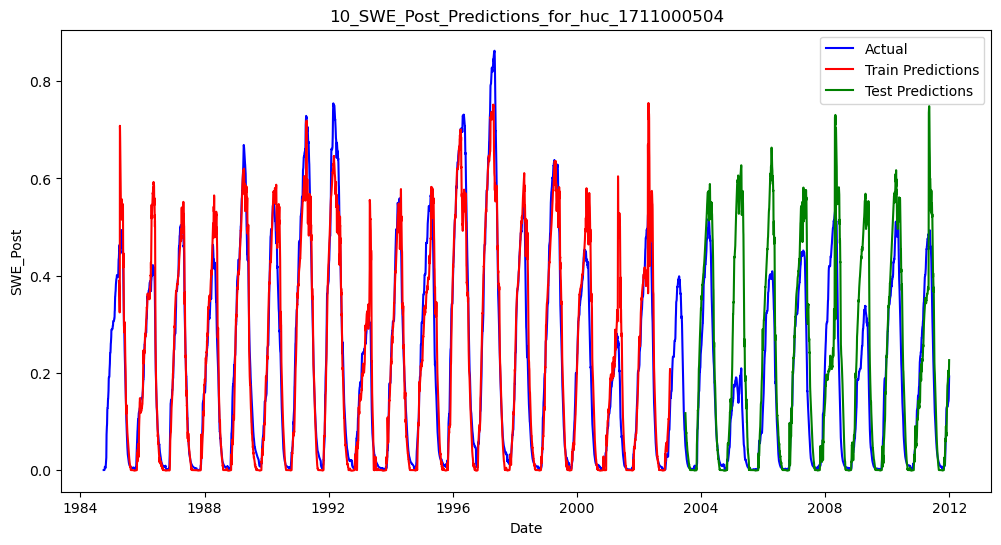

r: 0.8434150762320736, alpha: 1.2899253368377686, beta: 1.3572313785552979
r: 0.9544639448067863, alpha: 0.9969004392623901, beta: 1.0108177661895752
[0.00429762, 0.016648695, 0.04106658, 0.08452785, 0.9090712070465088, 0.38851773738861084, 0.9530940977630975, 0.5140063816093678]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.004298       67.144875
1       180  snotel   test_mse  0.016649       67.144875
2       180  snotel  train_mae  0.041067       67.144875
3       180  snotel   test_mae  0.084528       67.144875
4       180  snotel   train_r2  0.909071       67.144875
5       180  snotel    test_r2  0.388518       67.144875
6       180  snotel  train_kge  0.953094       67.144875
7       180  snotel   test_kge  0.514006       67.144875
 Files: wrf-skagit-1711000505-mean.csv and wus-sr-skagit-1711000505-mean-swe.csv
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip    

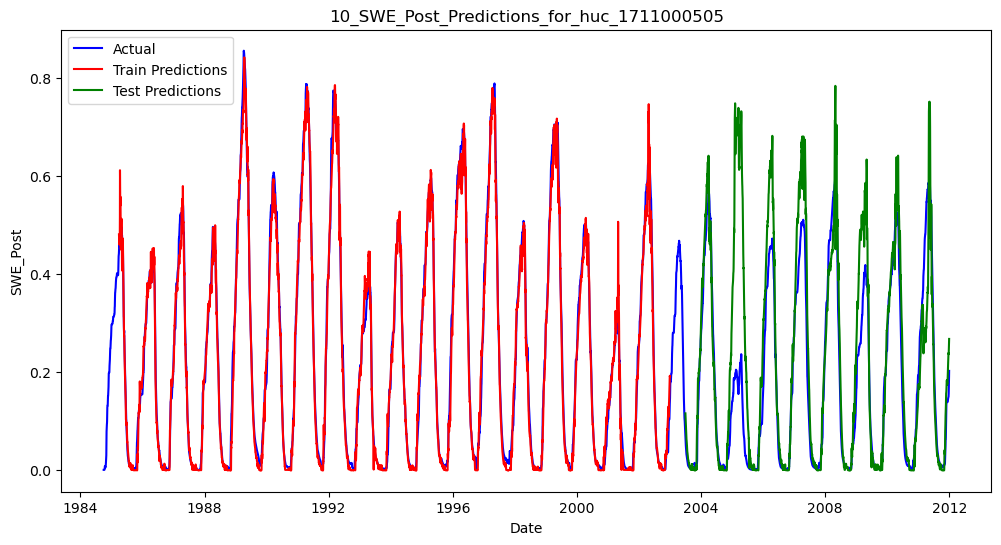

r: 0.8667882453820094, alpha: 1.1965333223342896, beta: 1.2415589094161987
r: 0.9943727927329675, alpha: 0.9791470170021057, beta: 0.9705365300178528
[0.00064705685, 0.014338161, 0.017603792, 0.067707226, 0.9875752925872803, 0.5842913389205933, 0.9634677070946059, 0.6612944862059361]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000647       71.115575
1       180  snotel   test_mse  0.014338       71.115575
2       180  snotel  train_mae  0.017604       71.115575
3       180  snotel   test_mae  0.067707       71.115575
4       180  snotel   train_r2  0.987575       71.115575
5       180  snotel    test_r2  0.584291       71.115575
6       180  snotel  train_kge  0.963468       71.115575
7       180  snotel   test_kge  0.661294       71.115575
 Files: wrf-skagit-1711000506-mean.csv and wus-sr-skagit-1711000506-mean-swe.csv
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip

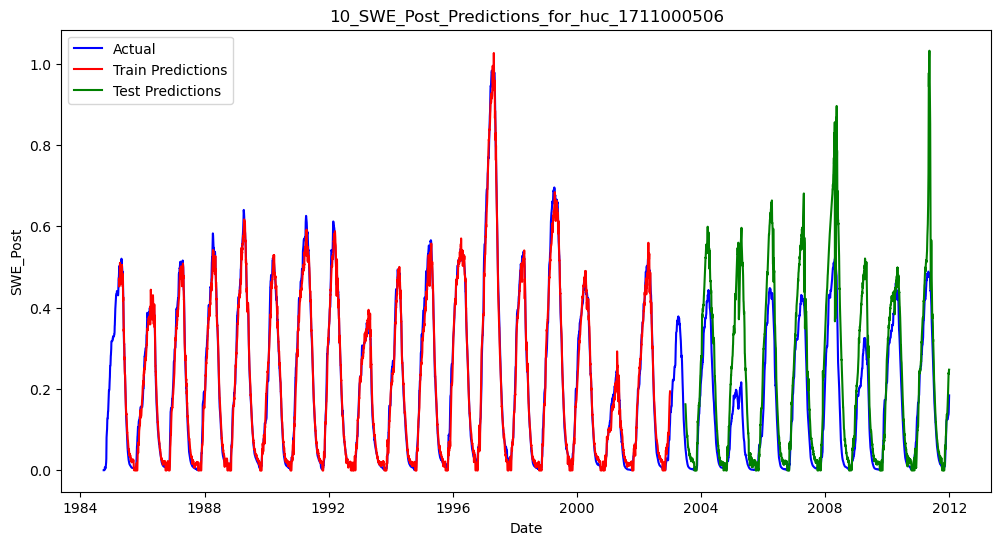

r: 0.9265238455343974, alpha: 1.3792608976364136, beta: 1.498224139213562
r: 0.9946772340064755, alpha: 0.9607056975364685, beta: 0.980588436126709
[0.0005474346, 0.014813988, 0.017629797, 0.083563596, 0.9878038167953491, 0.4026048183441162, 0.955850448972564, 0.3695518525317676]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000547       70.230698
1       180  snotel   test_mse  0.014814       70.230698
2       180  snotel  train_mae  0.017630       70.230698
3       180  snotel   test_mae  0.083564       70.230698
4       180  snotel   train_r2  0.987804       70.230698
5       180  snotel    test_r2  0.402605       70.230698
6       180  snotel  train_kge  0.955850       70.230698
7       180  snotel   test_kge  0.369552       70.230698
 Files: wrf-skagit-1711000507-mean.csv and wus-sr-skagit-1711000507-mean-swe.csv
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip    

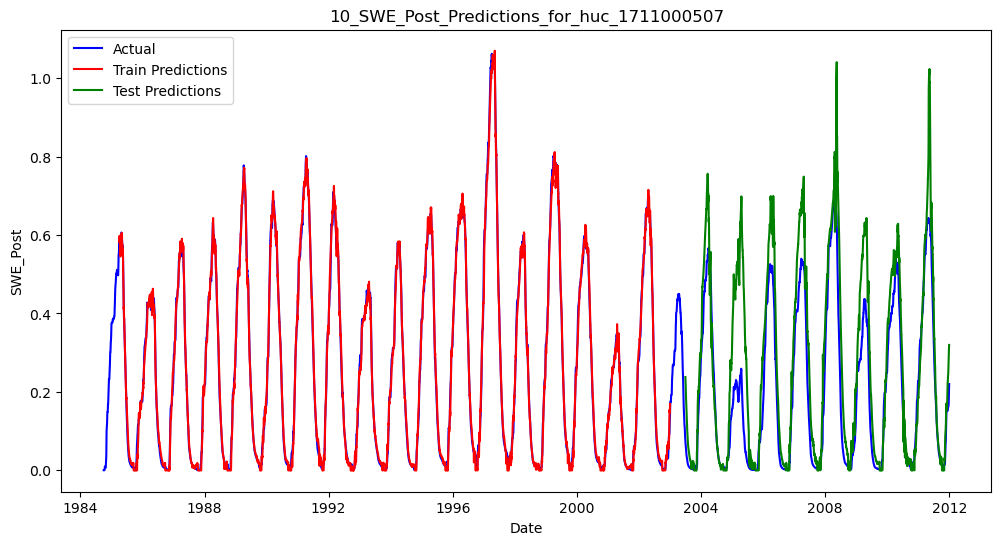

r: 0.9337359254459477, alpha: 1.2236391305923462, beta: 1.359484314918518
r: 0.9983573459424152, alpha: 0.9948214888572693, beta: 0.9979674816131592
[0.00020448309, 0.01414221, 0.010859057, 0.08081972, 0.996699869632721, 0.652357816696167, 0.994199446491831, 0.5714742003320666]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000204       70.464288
1       180  snotel   test_mse  0.014142       70.464288
2       180  snotel  train_mae  0.010859       70.464288
3       180  snotel   test_mae  0.080820       70.464288
4       180  snotel   train_r2  0.996700       70.464288
5       180  snotel    test_r2  0.652358       70.464288
6       180  snotel  train_kge  0.994199       70.464288
7       180  snotel   test_kge  0.571474       70.464288
 Files: wrf-skagit-1711000508-mean.csv and wus-sr-skagit-1711000508-mean-swe.csv
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip      

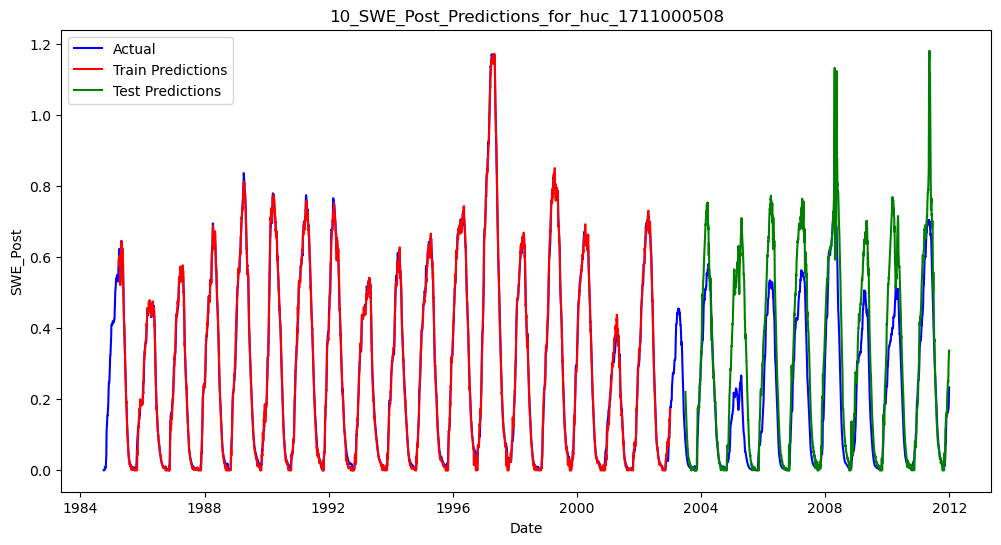

r: 0.9275198270984492, alpha: 1.288441777229309, beta: 1.4357142448425293
r: 0.9987344355366818, alpha: 1.0051259994506836, beta: 0.989707350730896
[0.00019045503, 0.021352889, 0.010173886, 0.100482434, 0.9972972273826599, 0.5277839303016663, 0.9884321068142894, 0.47245953949129493]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000190       80.387521
1       180  snotel   test_mse  0.021353       80.387521
2       180  snotel  train_mae  0.010174       80.387521
3       180  snotel   test_mae  0.100482       80.387521
4       180  snotel   train_r2  0.997297       80.387521
5       180  snotel    test_r2  0.527784       80.387521
6       180  snotel  train_kge  0.988432       80.387521
7       180  snotel   test_kge  0.472460       80.387521
 Files: wrf-skagit-1711000509-mean.csv and wus-sr-skagit-1711000509-mean-swe.csv
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip 

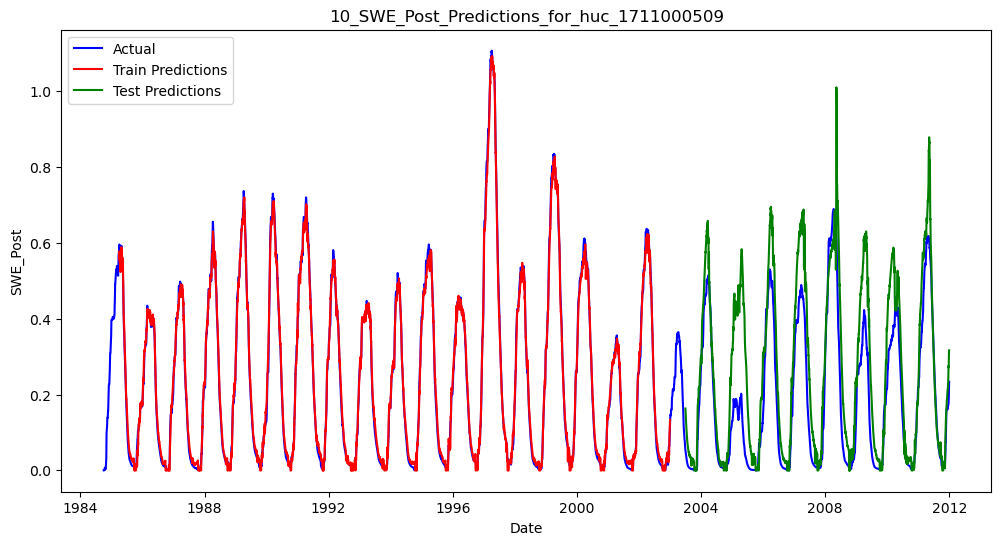

r: 0.919713599408716, alpha: 1.185148000717163, beta: 1.4254355430603027
r: 0.9985797621410905, alpha: 0.9704625606536865, beta: 1.0054340362548828
[0.00020488509, 0.014704022, 0.011407801, 0.08708841, 0.9963372349739075, 0.5960960984230042, 0.9699333049915291, 0.5291273106364296]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000205       68.629004
1       180  snotel   test_mse  0.014704       68.629004
2       180  snotel  train_mae  0.011408       68.629004
3       180  snotel   test_mae  0.087088       68.629004
4       180  snotel   train_r2  0.996337       68.629004
5       180  snotel    test_r2  0.596096       68.629004
6       180  snotel  train_kge  0.969933       68.629004
7       180  snotel   test_kge  0.529127       68.629004
 Files: wrf-skagit-1711000511-mean.csv and wus-sr-skagit-1711000511-mean-swe.csv
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip   

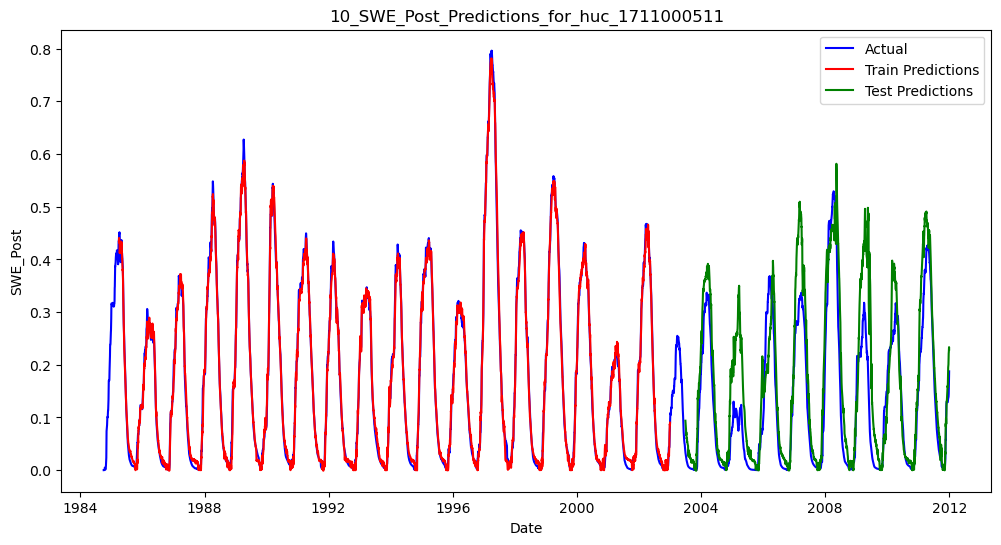

r: 0.9143759188482129, alpha: 1.1356704235076904, beta: 1.3165768384933472
r: 0.9978946284525018, alpha: 0.9810143113136292, beta: 0.9989376664161682
[0.00013517999, 0.005704849, 0.008996507, 0.054288074, 0.9955074787139893, 0.6939038634300232, 0.9808684157244586, 0.6450931928543964]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000135       68.757311
1       180  snotel   test_mse  0.005705       68.757311
2       180  snotel  train_mae  0.008997       68.757311
3       180  snotel   test_mae  0.054288       68.757311
4       180  snotel   train_r2  0.995507       68.757311
5       180  snotel    test_r2  0.693904       68.757311
6       180  snotel  train_kge  0.980868       68.757311
7       180  snotel   test_kge  0.645093       68.757311
🏃 View run intelligent-swan-675 at: https://us-west-2.experiments.sagemaker.aws/#/experiments/199/runs/904143d1cbfe4220afa7878fad6bd9ae
🧪 View experiment at: https://us-west-2.experiments.sagemaker.aws/

In [12]:
# Define the hyperparameters
input_size=2
hidden_size=2**6
num_class=1
num_layers=1
dropout = 0.5

learning_rate = 1e-3 #3e-3
n_epochs = 10
train_size_fraction = 0.67
lookback_values =  [180]


with mlflow.start_run():
    # log all the params
    mlflow.log_param("Training From", "Prototype Notebook")
    mlflow.log_param("input_size", input_size)
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("num_class", num_class)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("train_size_fraction", train_size_fraction)
    mlflow.log_param("lookback_values", lookback_values)
    mlflow.log_param("epochs", n_epochs)

    model_snotel = SnowModel(input_size, hidden_size, num_class, num_layers, dropout)
    optimizer_snotel = optim.Adam(model_snotel.parameters())
    loss_fn_snotel = nn.MSELoss()

    # List the files together, assuming they are related in chronological order and should be compared one-to-one
    for file1, file2 in zip(filenames1, filenames2):
        wrf_file = file1
        wus_file = file2
        print(f" Files: {wrf_file} and {wus_file}")
        huc_suff = file1[-11:-9]
        huc_no = f"17110005{huc_suff}"

        # Example usage of filter_and_merge_data
        filter_start_date = '1984-10-01'
        filter_end_date = '2011-12-31'
        filtered_data_start_data = '2005-01-01'
        filtered_data_end_data = '2007-12-31'

        # Assuming filter_and_merge_data is a function you have defined elsewhere
        data, filtered_data = filter_and_merge_data(wrf_file, wus_file, filter_start_date, filter_end_date, filtered_data_start_data, filtered_data_end_data)

        # train-test split for time series

        print(data.isna().sum())
        data = data.fillna(method='bfill')

        nan_rows = data[data.isna().any(axis=1)]
        print(nan_rows)

        print(data.isna().sum())
        train_size_main = int(len(data) * 0.67)
        test_size_main = len(data) - train_size_main
        train_main, test_main = data[:train_size_main], data[train_size_main:]

        print(train_size_main,test_size_main)


        # train-test split for time series
        test_size_filtered = int(len(filtered_data))
        test_filtered = filtered_data[:train_size_main]


        # Usage example
        lookback_values =  [180]
        results = []

        for lookback in lookback_values:
            print(f"\nLookback: {lookback}")
            start_time = time.time()

            # Snotel dataset
            X_train_snotel, y_train_snotel = create_dataset(train_main, lookback)
            X_test_snotel, y_test_snotel = create_dataset(test_main, lookback)

            # TO DO - REVERT NUMBER OF EPOCHS TO 200 TO MATCH ORIG NOTEBOOK 
            train_model(model_snotel, optimizer_snotel, loss_fn_snotel, X_train_snotel, y_train_snotel, n_epochs=n_epochs, batch_size=8) 
            predict(data,model_snotel,  X_train_snotel,X_test_snotel, lookback, train_size_main, huc_no, n_epochs)
            snotel_metrics = evaluate_metrics(model_snotel, X_train_snotel, y_train_snotel, X_test_snotel, y_test_snotel)
            print(snotel_metrics)
            elapsed_time = time.time() - start_time

            results.append([lookback, 'snotel', 'train_mse', snotel_metrics[0], elapsed_time])
            results.append([lookback, 'snotel', 'test_mse', snotel_metrics[1], elapsed_time])
            results.append([lookback, 'snotel', 'train_mae', snotel_metrics[2], elapsed_time])
            results.append([lookback, 'snotel', 'test_mae', snotel_metrics[3], elapsed_time])
            results.append([lookback, 'snotel', 'train_r2', snotel_metrics[4], elapsed_time])
            results.append([lookback, 'snotel', 'test_r2', snotel_metrics[5], elapsed_time])
            results.append([lookback, 'snotel', 'train_kge', snotel_metrics[6], elapsed_time])
            results.append([lookback, 'snotel', 'test_kge', snotel_metrics[7], elapsed_time])

            mlflow.log_metric(f"{huc_no}_train_mse", snotel_metrics[0])
            mlflow.log_metric(f"{huc_no}_test_mse", snotel_metrics[1])
            mlflow.log_metric(f"{huc_no}_train_kge", snotel_metrics[6])
            mlflow.log_metric(f"{huc_no}_test_kge", snotel_metrics[7])

        


        # Create a DataFrame for the results
        df_results = pd.DataFrame(results, columns=['Lookback', 'Dataset', 'Metric', 'Value', 'Time Taken (s)'])

        # Print the DataFrame
        print(df_results)